just want more ram...

In [0]:
# a = []
# while(1):
#     a.append('1')

## Setting & Import packages

In [2]:
!pip install catboost

In [3]:
!nvidia-smi

Tue Apr 14 02:32:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [5]:
import os
import gc
import re
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostRegressor, Pool

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
drive.mount('/melissakou', force_remount = True)

Mounted at /melissakou


In [0]:
os.chdir('/melissakou/My Drive/Colab Notebooks/m5')

In [0]:
sales = pd.read_csv('m5-forecasting-accuracy/sales_train_validation.csv')
calendar = pd.read_csv('m5-forecasting-accuracy/calendar.csv')
prices = pd.read_csv('m5-forecasting-accuracy/sell_prices.csv')

## Preprocessing

### calendar

In [9]:
calendar = calendar.drop(columns = ['date', 'weekday', 'event_name_2', 'event_type_2'])
calendar[['event_name_1', 'event_type_1']] = calendar[['event_name_1', 'event_type_1']].fillna('none')
#calendar[['event_name_1', 'event_type_1']] = OrdinalEncoder().fit_transform(calendar[['event_name_1', 'event_type_1']]).astype('int')
calendar['wday'] = calendar['wday'] - 1
calendar['d'] = calendar.d.str[2:].astype('int')
calendar

,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI
0,11101,0,1,2011,1,none,none,0,0,0
1,11101,1,1,2011,2,none,none,0,0,0
2,11101,2,1,2011,3,none,none,0,0,0
3,11101,3,2,2011,4,none,none,1,1,0
4,11101,4,2,2011,5,none,none,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1964,11620,4,6,2016,1965,none,none,0,1,1
1965,11620,5,6,2016,1966,none,none,0,0,0
1966,11620,6,6,2016,1967,none,none,0,0,0
1967,11621,0,6,2016,1968,none,none,0,0,0


### prices

In [10]:
gr = prices.groupby(["store_id", "item_id"])["sell_price"]
prices['price_pct_change'] = gr.pct_change()
prices['price_discount'] = prices['sell_price'] / gr.cummax()
prices['price_roll_std_7'] = gr.transform(lambda x: x.rolling(7).std())
del gr
gc.collect()

prices.head()

0

,store_id,item_id,wm_yr_wk,sell_price,price_pct_change,price_discount,price_roll_std_7
0,CA_1,HOBBIES_1_001,11325,9.58,NaN,1.000000,NaN
1,CA_1,HOBBIES_1_001,11326,9.58,0.000000,1.000000,NaN
2,CA_1,HOBBIES_1_001,11327,8.26,-0.137787,0.862213,NaN
3,CA_1,HOBBIES_1_001,11328,8.26,0.000000,0.862213,NaN
4,CA_1,HOBBIES_1_001,11329,8.26,0.000000,0.862213,NaN


### sales

In [0]:
drop = 1000
sales = sales.drop(columns = ["d_" + str(i+1) for i in range(drop-1)])
sales = sales.reindex(columns = sales.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])
sales.id = sales.id.str.replace('_validation', '')

In [12]:
sales = sales.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                   var_name='d', value_name='demand')
gc.collect()

24

In [13]:
gr = sales.groupby(['id'])['demand']
sales['demand_lag_28'] = gr.transform(lambda x: x.shift(28))
sales['demand_lag_35'] = gr.transform(lambda x: x.shift(35))
sales['demand_lag_42'] = gr.transform(lambda x: x.shift(42))
sales['demand_lag_49'] = gr.transform(lambda x: x.shift(49))
sales['roll_mean_7'] = gr.transform(lambda x: x.shift(28).rolling(7).mean())
sales['roll_mean_30'] = gr.transform(lambda x: x.shift(28).rolling(30).mean())
sales['roll_mean_60'] = gr.transform(lambda x: x.shift(28).rolling(60).mean())
sales['roll_mean_90'] = gr.transform(lambda x: x.shift(28).rolling(90).mean())
sales['roll_mean_180'] = gr.transform(lambda x: x.shift(28).rolling(180).mean())
sales['roll_std_7'] = gr.transform(lambda x: x.shift(28).rolling(7).std())
sales['roll_std_30'] = gr.transform(lambda x: x.shift(28).rolling(30).mean())

del gr
gc.collect()

sales['d'] = sales.d.str[2:].astype('int')
gc.collect()
sales = sales[(sales.d >= 1914) | (pd.notna(sales.roll_mean_180))]
sales.head()
sales.shape
gc.collect()

0

12

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,demand_lag_28,demand_lag_35,demand_lag_42,demand_lag_49,roll_mean_7,roll_mean_30,roll_mean_60,roll_mean_90,roll_mean_180,roll_std_7,roll_std_30
6311430,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1207,0.0,1.0,0.0,1.0,0.0,0.714286,0.400000,0.400000,0.400000,0.511111,0.755929,0.400000
6311431,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1207,0.0,0.0,0.0,0.0,0.0,0.142857,0.133333,0.116667,0.111111,0.138889,0.377964,0.133333
6311432,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1207,0.0,0.0,0.0,0.0,1.0,0.285714,0.433333,0.333333,0.333333,0.166667,0.487950,0.433333
6311433,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1207,2.0,1.0,1.0,2.0,1.0,2.142857,2.366667,2.466667,2.400000,2.322222,1.214986,2.366667
6311434,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1207,0.0,0.0,2.0,0.0,0.0,1.000000,0.733333,0.783333,0.877778,0.822222,1.154701,0.733333


(23263870, 19)

0

### merge data

In [14]:
sales = pd.merge(sales, calendar, how = 'left', on = 'd')
del calendar
gc.collect()
sales = pd.merge(sales, prices, how = "left", on = ["store_id", "item_id", "wm_yr_wk"])
del prices
gc.collect()
sales.drop(columns = ["wm_yr_wk"])
gc.collect()

0

0

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,demand_lag_28,demand_lag_35,demand_lag_42,demand_lag_49,roll_mean_7,roll_mean_30,roll_mean_60,roll_mean_90,roll_mean_180,roll_std_7,roll_std_30,wday,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,price_pct_change,price_discount,price_roll_std_7
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1207,0.0,1.0,0.0,1.0,0.0,0.714286,0.400000,0.400000,0.400000,0.511111,0.755929,0.400000,2,5,2014,none,none,0,0,0,8.26,0.0,0.862213,1.360284e-08
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1207,0.0,0.0,0.0,0.0,0.0,0.142857,0.133333,0.116667,0.111111,0.138889,0.377964,0.133333,2,5,2014,none,none,0,0,0,3.97,0.0,1.000000,0.000000e+00
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1207,0.0,0.0,0.0,0.0,1.0,0.285714,0.433333,0.333333,0.333333,0.166667,0.487950,0.433333,2,5,2014,none,none,0,0,0,2.97,0.0,1.000000,0.000000e+00
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1207,2.0,1.0,1.0,2.0,1.0,2.142857,2.366667,2.466667,2.400000,2.322222,1.214986,2.366667,2,5,2014,none,none,0,0,0,4.64,0.0,1.000000,1.226143e-08
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1207,0.0,0.0,2.0,0.0,0.0,1.000000,0.733333,0.783333,0.877778,0.822222,1.154701,0.733333,2,5,2014,none,none,0,0,0,3.08,0.0,1.000000,1.432744e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23263865,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6,2016,NBAFinalsEnd,Sporting,0,0,0,2.98,0.0,1.000000,1.753098e-08
23263866,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6,2016,NBAFinalsEnd,Sporting,0,0,0,2.48,0.0,0.925373,0.000000e+00
23263867,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6,2016,NBAFinalsEnd,Sporting,0,0,0,3.98,0.0,0.908676,2.404665e-08
23263868,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6,2016,NBAFinalsEnd,Sporting,0,0,0,1.28,0.0,1.000000,0.000000e+00


11

In [0]:
# v = ['item_id', 'dept_id', 'store_id', 'cat_id', 'state_id']
# sales[v] = OrdinalEncoder().fit_transform(sales[v]).astype('int')

# del v
# gc.collect()

# sales.head()

In [0]:
# sales.to_csv('sales.csv', index = False)

In [0]:
# sales = pd.read_csv('sales.csv')
# sales

## Model

### test data preparation

In [18]:
test = sales[sales.d >= 1914]
test = test.assign(id = test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),
                   F = "F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))
test

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,demand_lag_28,demand_lag_35,demand_lag_42,demand_lag_49,roll_mean_7,roll_mean_30,roll_mean_60,roll_mean_90,roll_mean_180,roll_std_7,roll_std_30,wm_yr_wk,wday,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,price_pct_change,price_discount,price_roll_std_7,F
21556430,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1914,NaN,1.0,1.0,0.0,0.0,1.142857,1.033333,0.983333,0.944444,0.772222,0.690066,1.033333,11613,2,4,2016,none,none,0,0,0,8.38,0.0,0.874739,6.414270e-02,F1
21556431,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1914,NaN,1.0,0.0,0.0,1.0,0.714286,0.333333,0.250000,0.211111,0.377778,0.487950,0.333333,11613,2,4,2016,none,none,0,0,0,3.97,0.0,1.000000,0.000000e+00,F1
21556432,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1914,NaN,0.0,0.0,0.0,1.0,0.285714,0.500000,0.416667,0.344444,0.633333,0.487950,0.500000,11613,2,4,2016,none,none,0,0,0,2.97,0.0,1.000000,0.000000e+00,F1
21556433,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1914,NaN,0.0,4.0,3.0,3.0,3.000000,1.966667,2.100000,2.033333,1.900000,2.708013,1.966667,11613,2,4,2016,none,none,0,0,0,4.64,0.0,1.000000,1.226143e-08,F1
21556434,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1914,NaN,1.0,2.0,2.0,2.0,0.714286,1.100000,1.133333,0.966667,1.172222,1.112697,1.100000,11613,2,4,2016,none,none,0,0,0,2.88,0.0,0.935065,1.430725e-08,F1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23263865,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11621,1,6,2016,NBAFinalsEnd,Sporting,0,0,0,2.98,0.0,1.000000,1.753098e-08,F28
23263866,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11621,1,6,2016,NBAFinalsEnd,Sporting,0,0,0,2.48,0.0,0.925373,0.000000e+00,F28
23263867,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11621,1,6,2016,NBAFinalsEnd,Sporting,0,0,0,3.98,0.0,0.908676,2.404665e-08,F28
23263868,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11621,1,6,2016,NBAFinalsEnd,Sporting,0,0,0,1.28,0.0,1.000000,0.000000e+00,F28


### train & validation data for LGBM

In [19]:
sales = sales[sales.d < 1914]
gc.collect()

0

In [20]:
gc.collect()

0

In [21]:
x = list(sales.columns)
for v in ['id', 'd', 'demand', 'wm_yr_wk']:
    x.remove(v)
x
gc.collect()

['item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'demand_lag_28',
 'demand_lag_35',
 'demand_lag_42',
 'demand_lag_49',
 'roll_mean_7',
 'roll_mean_30',
 'roll_mean_60',
 'roll_mean_90',
 'roll_mean_180',
 'roll_std_7',
 'roll_std_30',
 'wday',
 'month',
 'year',
 'event_name_1',
 'event_type_1',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'sell_price',
 'price_pct_change',
 'price_discount',
 'price_roll_std_7']

22

In [0]:
val_ind = sales.d >= 1914 - 28
train_X = sales[~val_ind][x]
train_Y = sales[~val_ind]['demand']
val_X = sales[val_ind][x]
val_Y = sales[val_ind]['demand']

In [23]:
val_sub = sales[val_ind]
val_sub = val_sub.assign(F = "F" + (val_sub.d - 1885).astype("str"))
val_sub
gc.collect()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,demand_lag_28,demand_lag_35,demand_lag_42,demand_lag_49,roll_mean_7,roll_mean_30,roll_mean_60,roll_mean_90,roll_mean_180,roll_std_7,roll_std_30,wm_yr_wk,wday,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,price_pct_change,price_discount,price_roll_std_7,F
20702710,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1886,1.0,0.0,4.0,0.0,2.0,1.142857,1.000000,0.883333,0.833333,0.711111,1.463850e+00,1.000000,11609,2,3,2016,none,none,0,0,0,8.26,0.0,0.862213,1.360284e-08,F1
20702711,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1886,1.0,0.0,0.0,0.0,1.0,0.142857,0.166667,0.150000,0.400000,0.366667,3.779645e-01,0.166667,11609,2,3,2016,none,none,0,0,0,3.97,0.0,1.000000,0.000000e+00,F1
20702712,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1886,0.0,0.0,0.0,0.0,0.0,0.000000,0.300000,0.250000,0.655556,0.661111,5.071505e-08,0.300000,11609,2,3,2016,none,none,0,0,0,2.97,0.0,1.000000,0.000000e+00,F1
20702713,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1886,0.0,0.0,2.0,0.0,4.0,1.857143,2.200000,2.066667,1.922222,1.883333,2.115701e+00,2.200000,11609,2,3,2016,none,none,0,0,0,4.64,0.0,1.000000,1.226143e-08,F1
20702714,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1886,1.0,1.0,0.0,2.0,1.0,1.000000,1.133333,0.916667,1.100000,1.188889,1.000000e+00,1.133333,11609,2,3,2016,none,none,0,0,0,2.88,0.0,0.935065,1.430725e-08,F1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21556425,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1913,1.0,0.0,0.0,0.0,1.0,0.000000,0.266667,0.500000,0.611111,0.677778,3.547186e-08,0.266667,11613,1,4,2016,none,none,0,0,0,2.98,0.0,1.000000,1.753098e-08,F28
21556426,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1913,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,11613,1,4,2016,none,none,0,0,0,2.48,0.0,0.925373,2.565708e-01,F28
21556427,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1913,0.0,1.0,0.0,1.0,2.0,0.714286,1.233333,0.933333,0.900000,0.638889,9.511897e-01,1.233333,11613,1,4,2016,none,none,0,0,0,3.98,0.0,0.908676,2.404665e-08,F28
21556428,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1913,3.0,4.0,1.0,3.0,2.0,1.571429,1.166667,1.100000,1.188889,1.405556,1.272418e+00,1.166667,11613,1,4,2016,none,none,0,0,0,1.28,0.0,1.000000,0.000000e+00,F28


0

In [24]:
del val_ind, sales
gc.collect()

0

### model training

In [0]:
cat_fea = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
           'wday', 'month', 'year', 'event_name_1', 'event_type_1']

#cat_fea = ['item_id', 'store_id', 'wday', 'month', 'year', 'event_name_1']

In [26]:
gc.collect()

0

In [27]:
train_pool = Pool(train_X, train_Y, cat_features = cat_fea)
val_pool = Pool(val_X, val_Y, cat_features = cat_fea)

del train_X, train_Y
gc.collect()

0

In [28]:
val_X

,item_id,dept_id,cat_id,store_id,state_id,demand_lag_28,demand_lag_35,demand_lag_42,demand_lag_49,roll_mean_7,roll_mean_30,roll_mean_60,roll_mean_90,roll_mean_180,roll_std_7,roll_std_30,wday,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,price_pct_change,price_discount,price_roll_std_7
20702710,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.0,4.0,0.0,2.0,1.142857,1.000000,0.883333,0.833333,0.711111,1.463850e+00,1.000000,2,3,2016,none,none,0,0,0,8.26,0.0,0.862213,1.360284e-08
20702711,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,1.0,0.142857,0.166667,0.150000,0.400000,0.366667,3.779645e-01,0.166667,2,3,2016,none,none,0,0,0,3.97,0.0,1.000000,0.000000e+00
20702712,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,0.000000,0.300000,0.250000,0.655556,0.661111,5.071505e-08,0.300000,2,3,2016,none,none,0,0,0,2.97,0.0,1.000000,0.000000e+00
20702713,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0.0,2.0,0.0,4.0,1.857143,2.200000,2.066667,1.922222,1.883333,2.115701e+00,2.200000,2,3,2016,none,none,0,0,0,4.64,0.0,1.000000,1.226143e-08
20702714,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1.0,0.0,2.0,1.0,1.000000,1.133333,0.916667,1.100000,1.188889,1.000000e+00,1.133333,2,3,2016,none,none,0,0,0,2.88,0.0,0.935065,1.430725e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21556425,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0.0,0.0,0.0,1.0,0.000000,0.266667,0.500000,0.611111,0.677778,3.547186e-08,0.266667,1,4,2016,none,none,0,0,0,2.98,0.0,1.000000,1.753098e-08
21556426,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1,4,2016,none,none,0,0,0,2.48,0.0,0.925373,2.565708e-01
21556427,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1.0,0.0,1.0,2.0,0.714286,1.233333,0.933333,0.900000,0.638889,9.511897e-01,1.233333,1,4,2016,none,none,0,0,0,3.98,0.0,0.908676,2.404665e-08
21556428,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,4.0,1.0,3.0,2.0,1.571429,1.166667,1.100000,1.188889,1.405556,1.272418e+00,1.166667,1,4,2016,none,none,0,0,0,1.28,0.0,1.000000,0.000000e+00


In [0]:
model = CatBoostRegressor(iterations = 2000,
                          learning_rate = 0.08,
                          early_stopping_rounds = 400,
                          depth = 7,
                          # max_leaves = 36,
                          # bagging_temperature = 30,
                          random_strength = 0.5,
                          l2_leaf_reg = 0.1,
                          #one_hot_max_size = 255,
                          border_count = 255,
                          feature_border_type = '',
                          ctr_target_border_count = 1,
                          #simple_ctr = ['Borders:TargetBorderType=Uniform', 'Borders:TargetBorderCount=1'],
                          has_time = True,
                          loss_function = 'RMSE',
                          eval_metric = 'RMSE',
                          task_type = 'GPU',
                          #grow_policy = 'Lossguide',
                          verbose = 50)
model.fit(X = train_pool, eval_set = val_pool)

0:	learn: 3.4480247	test: 3.4377734	best: 3.4377734 (0)	total: 1.22s	remaining: 40m 42s
50:	learn: 2.2158014	test: 2.1716537	best: 2.1716537 (50)	total: 55.6s	remaining: 35m 25s
100:	learn: 2.1626980	test: 2.1535592	best: 2.1535592 (100)	total: 1m 45s	remaining: 32m 57s
150:	learn: 2.1383768	test: 2.1453838	best: 2.1452830 (148)	total: 2m 36s	remaining: 31m 56s
200:	learn: 2.1219956	test: 2.1437737	best: 2.1437149 (171)	total: 3m 26s	remaining: 30m 49s
250:	learn: 2.1062251	test: 2.1366098	best: 2.1366098 (250)	total: 4m 16s	remaining: 29m 44s
300:	learn: 2.0944210	test: 2.1355915	best: 2.1348068 (272)	total: 5m 6s	remaining: 28m 50s
350:	learn: 2.0850616	test: 2.1344238	best: 2.1344238 (350)	total: 5m 57s	remaining: 27m 58s
400:	learn: 2.0770150	test: 2.1343043	best: 2.1342503 (399)	total: 6m 48s	remaining: 27m 8s


In [0]:
# model.save_model('catboost.cbm')

In [0]:
# model = CatBoostRegressor()
# model.load_model('catboost.cbm')

In [42]:
#del train_pool, val_pool
gc.collect()

29

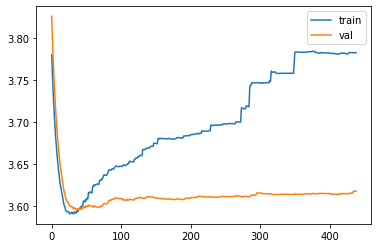

In [43]:
plt.plot(model.evals_result_['learn']['RMSE'], label = 'train')
plt.plot(model.evals_result_['validation']['RMSE'], label = 'val')
plt.legend()

<Figure size 720x432 with 0 Axes>

0

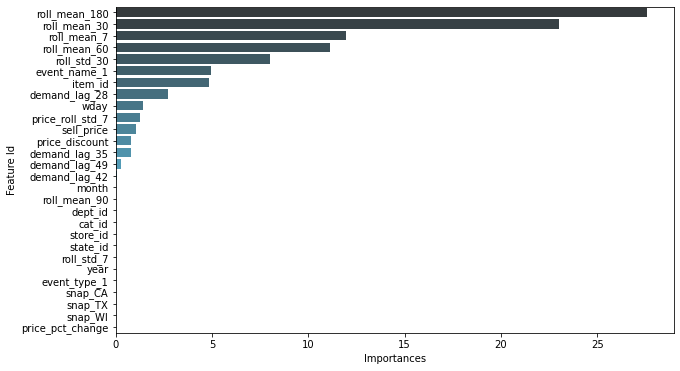

In [44]:
feature_imp = model.get_feature_importance(prettified = True)
plt.figure(figsize = (10, 6))
sns.barplot(y = feature_imp['Feature Id'], x = feature_imp['Importances'], palette = 'GnBu_d')
del feature_imp
gc.collect()

<Figure size 360x360 with 0 Axes>

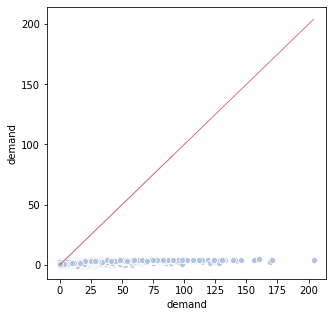

In [45]:
plt.figure(figsize = (5, 5))
#sns.scatterplot(val_Y, [max(0, x) for x in model.get_test_eval()], color = 'lightsteelblue')
sns.scatterplot(val_Y, model.get_test_eval(), color = 'lightsteelblue')
sns.lineplot(val_Y, val_Y, color = 'indianred', lw = 0.8)

In [0]:
# train_pred = model.predict()

In [0]:
# from sklearn.linear_model import LinearRegression
# model = LinearRegression(fit_intercept=True)

# model.fit(train_pred.reshape(-1, 1), train.get_label())

In [0]:
# model.coef_
# model.intercept_

In [0]:
# plt.figure(figsize = (5, 5))
# plt.scatter(train.get_label(), train_pred * 1.03)
# plt.plot(train.get_label(), train.get_label(), '-', color = 'red')

In [0]:
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())

        return np.mean(all_scores)

In [38]:
submission = pd.read_csv('m5-forecasting-accuracy/sample_submission.csv')
F = submission.columns
idx = submission.id
del submission
gc.collect()

val_sub['demand'] = [max(0, x) for x in model.get_test_eval()]
val_pred = val_sub.pivot(index = 'id', columns = 'F', values = 'demand').reset_index()[F]
val_pred['id'] = (val_pred['id'] + '_validation').astype('str')
val_pred['id'] = pd.Categorical(val_pred['id'], categories = idx)
val_pred = val_pred.sort_values(by = 'id')

gc.collect()
val_pred

7475

0

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
14370,HOBBIES_1_001_CA_1_validation,0.877206,0.789739,0.780355,0.790857,0.857872,1.087912,1.007648,0.807466,0.687859,0.687785,0.660491,0.868550,0.781473,0.811085,0.583619,0.544718,0.544673,0.611484,0.806662,0.956003,1.129943,0.820569,0.854115,0.835483,0.764777,0.870469,1.147957,1.114206
14380,HOBBIES_1_002_CA_1_validation,0.317673,0.278491,0.271905,0.313227,0.309358,0.391012,0.419411,0.353393,0.290344,0.277014,0.353410,0.353755,0.473826,0.496297,0.335682,0.274419,0.286145,0.301428,0.315332,0.385789,0.374158,0.267495,0.222031,0.233555,0.306909,0.350595,0.470257,0.522109
14390,HOBBIES_1_003_CA_1_validation,0.298329,0.272438,0.281699,0.287671,0.324778,0.703977,0.692077,0.532465,0.540801,0.526508,0.553259,0.575646,0.815760,0.675108,0.431170,0.366803,0.356849,0.357585,0.441583,0.710567,0.534935,0.368848,0.343705,0.325368,0.338291,0.409438,0.623869,0.566086
14400,HOBBIES_1_004_CA_1_validation,1.713231,1.440686,1.430313,1.412102,1.613218,1.915915,2.497462,1.641901,1.548034,1.513423,1.420170,1.406298,1.797245,2.105051,1.458829,1.198916,1.256802,1.382984,1.865746,2.090276,2.321646,1.888310,1.483636,1.625579,1.921924,1.732224,2.458571,2.759878
14410,HOBBIES_1_005_CA_1_validation,1.156672,1.132299,1.116237,1.036617,1.010561,1.280086,1.352325,1.052282,0.977363,0.956743,0.955509,1.140362,1.382820,1.479459,1.119679,1.029024,1.021890,0.913999,1.206697,1.396920,1.590401,1.286610,1.213953,1.185823,1.138559,1.265827,1.397598,1.322558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14329,FOODS_3_823_WI_3_validation,0.602729,0.490353,0.642612,0.605638,0.640671,1.023873,1.118806,0.776409,0.727278,0.782424,0.685645,0.743486,0.880690,0.728303,0.699973,0.665253,0.548777,0.636629,0.685813,0.468561,0.435534,0.286793,0.249493,0.249982,0.278481,0.324551,0.428181,0.416648
14339,FOODS_3_824_WI_3_validation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.092214,0.145695,0.117770,0.095509,0.061635,0.009170,0.059264,0.108418,0.090053,0.118566,0.021527,0.000000,0.000000,0.002886,0.042183,0.090053,0.118566
14349,FOODS_3_825_WI_3_validation,0.563752,0.573603,0.629196,0.728155,0.918984,1.221300,1.215137,0.927241,0.995259,1.019066,0.939549,1.126428,1.354705,1.184210,1.001478,1.052878,0.901122,0.926812,1.206990,1.203410,1.201851,0.980825,0.912508,0.888701,0.838365,0.984879,1.091227,1.142047
14359,FOODS_3_826_WI_3_validation,1.004216,0.995521,0.991718,1.050217,1.208751,1.539393,1.594307,1.019755,1.094153,1.027763,0.950251,1.046527,1.361368,1.324161,1.032785,1.090060,0.980512,1.016604,1.180839,1.391687,1.365075,1.001267,0.956237,0.979764,0.975873,1.145118,1.446902,1.689923


In [39]:
sales = pd.read_csv('m5-forecasting-accuracy/sales_train_validation.csv')
calendar = pd.read_csv('m5-forecasting-accuracy/calendar.csv')
prices = pd.read_csv('m5-forecasting-accuracy/sell_prices.csv')
train_fold_df = sales.iloc[:, :-28]
valid_fold_df = sales.iloc[:, -28:].copy()

del sales
gc.collect()

e = WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar, prices)

0

In [40]:
e.score(np.array(val_pred.iloc[:, 1:]))

0.5761154719952284

In [0]:
del e
gc.collect()

36

In [0]:
gc.collect()

0

## Predict for d_1914 ~ d_1941

In [0]:
pred = model.predict(test[x])
test['demand'] = pred

In [0]:
submission = test.pivot(index = 'id', columns = 'F', values = 'demand').reset_index()[F]
submission

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.336702,0.234100,0.237050,0.205776,0.269225,0.378656,0.361022,0.364946,0.214825,0.238137,0.241818,0.283407,0.384145,0.358743,0.317366,0.226785,0.240428,0.246607,0.285483,0.372823,0.362162,0.276267,0.253553,0.229699,0.242879,0.280521,0.356509,0.326795
1,FOODS_1_001_CA_1_validation,0.896146,0.802694,0.760422,0.739896,0.885557,1.018919,0.994496,1.023821,0.890004,0.927185,0.837318,0.982323,1.071178,1.014563,1.067113,0.856128,0.784949,0.795857,0.869048,1.041903,0.963504,0.980354,0.811674,0.858454,0.813781,0.868985,1.038278,0.990849
2,FOODS_1_001_CA_2_evaluation,0.231163,0.207464,0.206742,0.233981,0.226231,0.313347,0.712629,0.273788,0.188190,0.194781,0.247809,0.246315,0.331636,0.732217,0.258610,0.194826,0.202929,0.211572,0.252242,0.320077,0.344413,0.244308,0.218572,0.195223,0.210689,0.245240,0.326527,0.261033
3,FOODS_1_001_CA_2_validation,0.825552,0.728301,0.710993,0.721799,0.686499,0.861314,0.805547,0.665923,0.610640,0.623425,0.579562,0.652356,0.848479,0.666289,0.637666,0.574090,0.578113,0.524372,0.581018,0.687579,1.828496,0.948236,0.915842,0.917777,1.044614,1.018867,1.207236,1.875458
4,FOODS_1_001_CA_3_evaluation,0.335744,0.293080,0.279713,0.276308,0.304278,0.454133,0.751609,0.380561,0.293080,0.323117,0.318851,0.344982,0.444392,0.804620,0.384580,0.318720,0.324769,0.327457,0.354817,0.430222,0.405321,0.358666,0.325901,0.303284,0.308816,0.334733,0.412077,0.354582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,HOUSEHOLD_2_516_WI_1_validation,0.100261,0.072488,0.084054,0.095188,0.135232,0.184502,0.145149,0.113027,0.084269,0.096698,0.080324,0.144409,0.232376,0.091763,0.120036,0.086115,0.098433,0.120441,0.224129,0.264497,0.233134,0.175659,0.139101,0.152644,0.161688,0.166863,0.199713,0.165688
60976,HOUSEHOLD_2_516_WI_2_evaluation,0.074417,0.040883,0.058631,0.085703,0.103030,0.103297,0.075713,0.095038,0.040883,0.058217,0.091767,0.121184,0.094055,0.096104,0.095332,0.018349,0.076345,0.128430,0.101686,0.114880,0.101600,0.077121,0.063921,0.080727,0.066164,0.099733,0.092702,0.032539
60977,HOUSEHOLD_2_516_WI_2_validation,0.081841,0.055628,0.072664,0.075923,0.111616,0.097925,0.086239,0.125573,0.100357,0.085458,0.112764,0.158387,0.128614,0.056429,0.123685,0.060553,0.107627,0.136759,0.125906,0.139990,0.132679,0.089235,0.055702,0.073450,0.152429,0.178256,0.185986,0.150939
60978,HOUSEHOLD_2_516_WI_3_evaluation,0.052828,0.017734,0.030012,0.039055,0.080385,0.100649,0.089596,0.083114,0.017734,0.034264,0.048419,0.097019,0.096198,0.106983,0.072645,-0.000590,0.043621,0.068701,0.083830,0.117789,0.117094,0.064813,0.042554,0.052493,0.048154,0.086492,0.099460,0.053187


In [0]:
submission.to_csv('submission_0411_2.csv', index = False)